In [1]:
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
import glob
import pickle
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import preprocessing
from scipy.ndimage.measurements import label
from skimage.feature import hog
import numpy as np

In [2]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

#compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def color_spatial_transform(img, color_space='BGR'):
    if color_space is 'BGR':
        feature_image = np.copy(img)
    elif color_space is 'RGB':
        feature_image = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    elif color_space is 'HSV':
        feature_image = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    elif color_space is 'HLS':
        feature_image = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    elif color_space is 'YUV':
        feature_image = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
    elif color_space is 'GRAY':
        feature_image = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    elif color_space is 'YCrCb':
        feature_image = cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)
    return feature_image

# Compute color histogram features
def color_histogram(img , nbins = 32 , bins_range = (0,256)):
    if len(img.shape) < 3:
        hist_features = np.histogram(img, bins = nbins , range = bins_range)
    else:
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the feature vector
    return hist_features


# Calculate HOG features
def get_hog_features(img,orient = 9,pix_per_cell = 8 , cell_per_block = 2 ,vis = False , feature_vec = True):
    if vis is True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)#feature_vector=False)
        return features,hog_image
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features


# Calculates HOG features for single/multi channels
def hog_features(img, orient = 9, pix_per_cell = 8 , cell_per_block = 2 , feature_vec = True , vis = False):
    features = []
    for ch in range(3):
        hog_features = hog(img[:,:,ch], orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        features.append(hog_features)

    return features

#Extract features from image
def extract_features(directory, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    labels = []
    for file_path in directory:
        if 'non-vehicles' in  file_path:
            labels.append(0)
        else:
            labels.append(1)
        img_features = []
        img = cv2.imread(file_path)
        img = color_spatial_transform(img , space = color_space)
        if spatial_feat is True:
            spatial_features = bin_spatial(img,size = (32,32))
            img_features.append(spatial_features)            
        if hist_feat is True:
            # Apply color_histogram()
            color_features = color_histogram(img , nbins = hist_bins)
            img_features.append(color_features)            
        if hog_feat is True:
            HOG_features = hog_features(img,orient ,pix_per_cell , cell_per_block , feature_vec = True , vis = False)
            HOG_features = np.ravel(HOG_features)
            img_features.append(HOG_features)
           

        img_features = np.concatenate(img_features)
        features.append(img_features)
    features = np.array(features)
    labels = np.array(labels)
    data = {'data':features , 'labels':labels}
    pickle.dump(data , open('Data.p','wb'))
    print('Data set size : ', features.shape)
    return data

In [3]:
# Dataset paths
files_names = glob.glob('vehicle_detection_data/*/*/*.png') 
test_files = glob.glob('test_images/*.jpg')

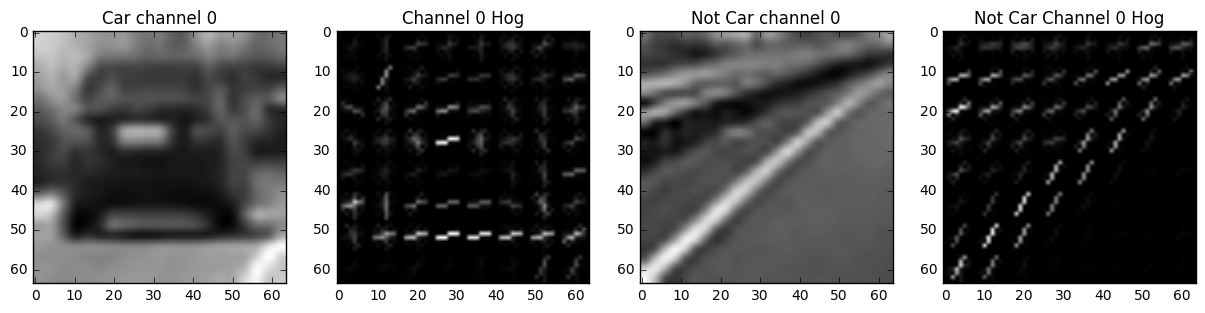

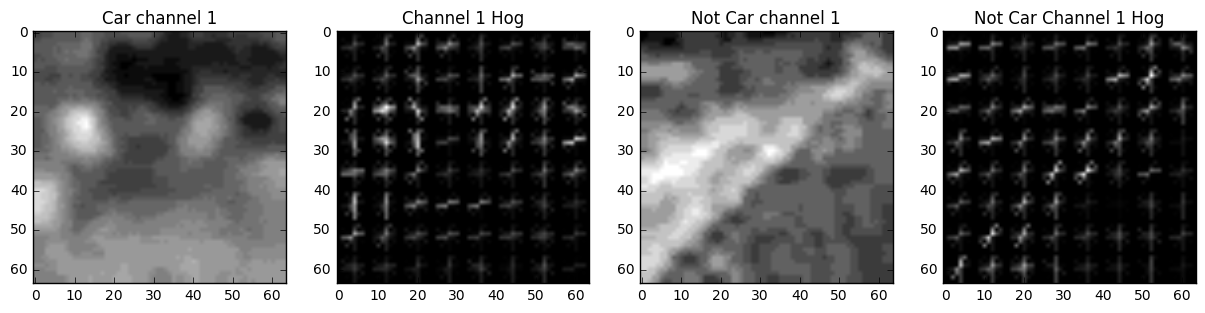

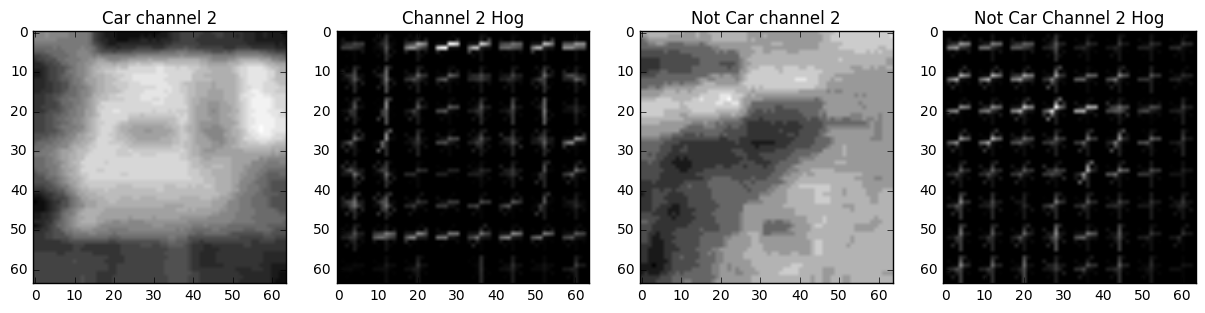

In [4]:
car = cv2.imread('vehicle_detection_data/vehicles/GTI_Far/image0000.png')
car = cv2.cvtColor(car,cv2.COLOR_BGR2YCrCb)
nocar = cv2.imread('vehicle_detection_data/non-vehicles/GTI/image13.png')
nocar = cv2.cvtColor(nocar,cv2.COLOR_BGR2YCrCb)
for ch in range(car.shape[2]):
    f,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize = (15,20))
    _,hog_car = get_hog_features(car[:,:,ch],vis = True , feature_vec = True)
    _,hog_nocar = get_hog_features(nocar[:,:,ch],vis = True , feature_vec = True)

    ax1.imshow(car[:,:,ch],cmap = 'gray')
    ax2.imshow(hog_car , cmap ='gray')
    ax3.imshow(nocar[:,:,ch],cmap = 'gray')
    ax4.imshow(hog_nocar , cmap ='gray')
    ax1.set_title('Car channel ' +str(ch))
    ax2.set_title('Channel '+str(ch)+' Hog')
    ax3.set_title('Not Car channel ' +str(ch))
    ax4.set_title('Not Car Channel '+str(ch)+' Hog')

    plt.show()

In [5]:
#Extract features from image files
features_extracted = True
data = []
if(features_extracted):
    data = pickle.load(open('Data.p','rb'))
else:
    data = extract_features(files_names, color_space='YCrCb', spatial_size=(32, 32),
                            hist_bins=32, orient=9,
                            pix_per_cell=8, cell_per_block=2,
                            spatial_feat=True, hist_feat=True, hog_feat=True)

In [6]:
#Load features
X = data['data']
y = data['labels']

In [7]:
#Shuffle data
concat = np.hstack((X,np.expand_dims(y,axis = 1))) 
np.random.shuffle(concat)
X = concat[:,:-1]
y = concat[:,-1]

In [8]:
#Normalize data 
scaler  = preprocessing.StandardScaler().fit(X)

X = scaler.transform(X)

In [9]:
#Split Train and test data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)
print('Training samples: ',X_train.shape)
print('Test samples: ',X_test.shape)

Training samples:  (14208, 8460)
Test samples:  (3552, 8460)


In [10]:
from sklearn.externals import joblib
from sklearn.svm import LinearSVC
use_pickled_model = True
if(not use_pickled_model):
    model = LinearSVC(C=0.1)
    model.fit(X_train,y_train)
    print('Training Completed')
    joblib.dump(model, 'classifier.pkl') 
    joblib.dump(scaler, 'scaler.pkl')
else:
    model = joblib.load('classifier.pkl')
    scaler = joblib.load('scaler.pkl')

In [11]:
train_accuracy = model.score(X_train,y_train)
test_accuracy = model.score(X_test,y_test)
print('Training accuracy: ',train_accuracy)
print('Testing accuracy: ',test_accuracy)

Training accuracy:  0.998310810811
Testing accuracy:  0.998592342342


In [12]:
#Extract features using hog sub-sampling and make predictions
def find_cars(img,scale =1.5):
    draw = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    scaled_img = img
    ytop = int(img.shape[0]//2)
    scaled_img = scaled_img[ytop:,:,:]
    imshape = scaled_img.shape
    if scale != 1:
        scaled_img = cv2.resize(scaled_img , (int(imshape[1]/scale),int(imshape[0]/scale)))
        imshape = scaled_img.shape
    scaled_img = color_spatial_transform(scaled_img, color_space = 'YCrCb')
    
    window = 64
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    feat_per_block = orient * cell_per_block**2
    nx_blocks = (imshape[1] // pix_per_cell) - 1
    ny_blocks = (imshape[0] // pix_per_cell) - 1
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2 
    nxsteps = (nx_blocks - nblocks_per_window) // cells_per_step
    nysteps = (ny_blocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    Hog_features = hog_features(scaled_img,orient,pix_per_cell , cell_per_block , feature_vec = False)
    hog1 = Hog_features[0]
    hog2 = Hog_features[1]
    hog3 = Hog_features[2]

    for xb in range(nxsteps):
        for yb in range(nysteps):
            xpos = xb*cells_per_step
            ypos = yb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            Hog_features = np.hstack((hog_feat1,hog_feat2,hog_feat3))
            
            xleft = xpos * pix_per_cell
            y_top = ypos * pix_per_cell
            
            # Extract the image patch
            img_patch = scaled_img[y_top:y_top+window,xleft:xleft+window,:]
            
            # Get color features
            spatial_features = bin_spatial(img_patch)
            color_features = color_histogram(img_patch)
            features = np.concatenate((spatial_features,color_features,Hog_features))
            features = np.expand_dims(features,axis = 0)
            
            # Scale features and make a prediction
            test_features = scaler.transform(features)                       
            test_prediction = model.predict(test_features)
            
            if(test_prediction == 1 ):                
                xbox_left = int(xleft * scale)
                ytop_draw = int(y_top * scale)
                win_draw = int(window * scale)
                
                 # Add += 1 for all pixels inside each bbox
                heatmap[ytop_draw+ytop:ytop_draw+ytop+win_draw,xbox_left:xbox_left+win_draw] += 1
                cv2.rectangle(draw,(xbox_left , ytop_draw+ytop),(xbox_left+win_draw,ytop_draw+ytop+win_draw),(255,0,0),6)
    # Draw box and return updated heatmap
    return draw , heatmap            


def apply_threshold(heatmap,threshold):
     # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap
    
def draw_labeled_boxes(img,labels):
    # Iterate through all detected cars
    for car in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        max_x, min_x, max_y, min_y = np.max(nonzerox), np.min(nonzerox), np.max(nonzeroy), np.min(nonzeroy)
        if( (max_x - min_x >55) and (max_y - min_y > 55) ):
            bbox = ((min_x, min_y), (max_x, max_y))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

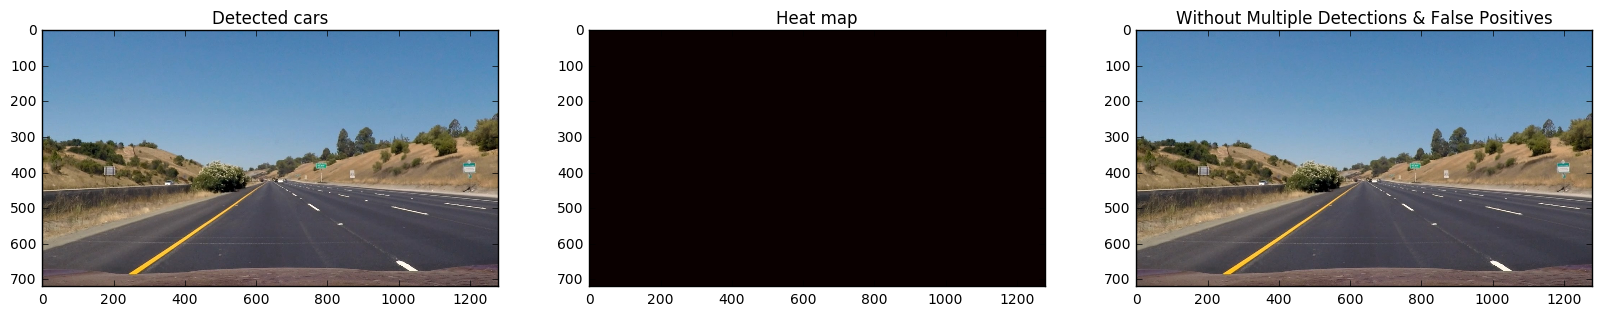

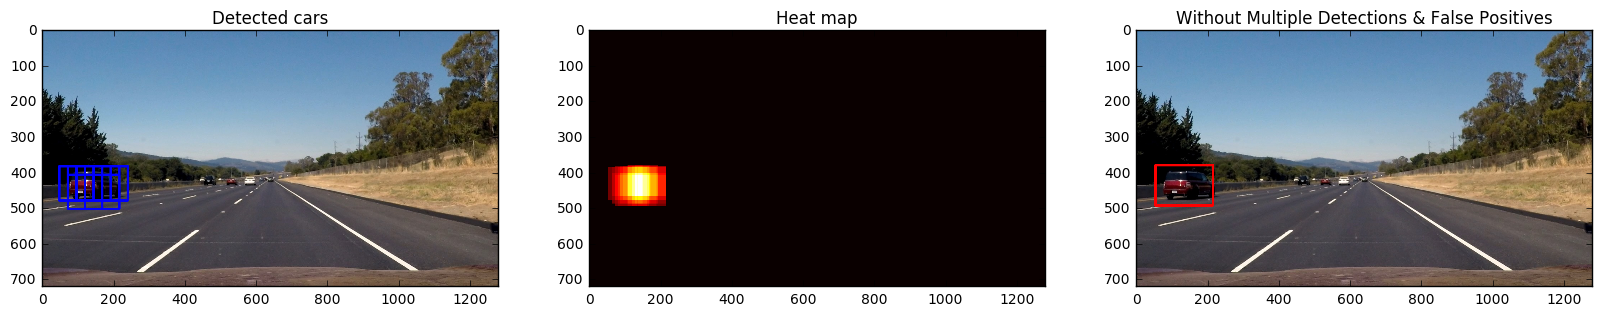

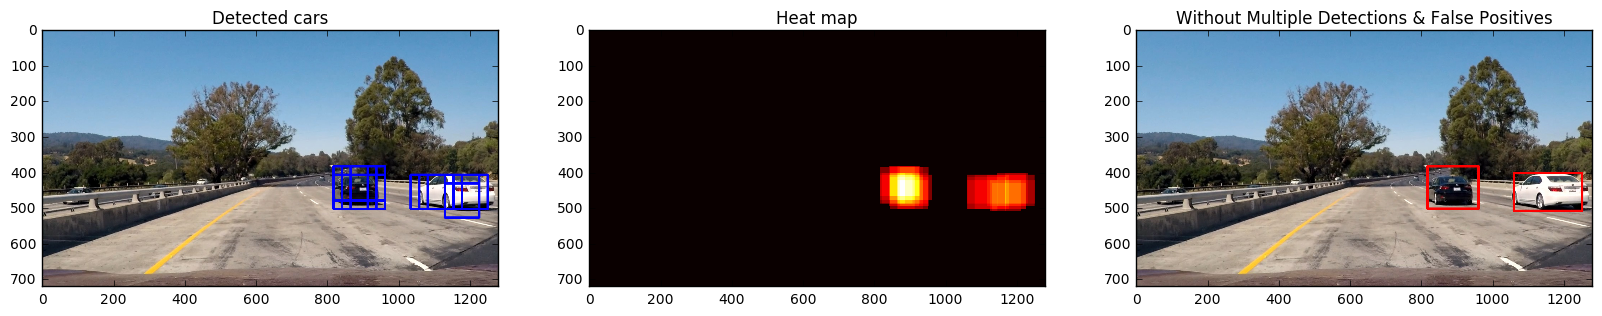

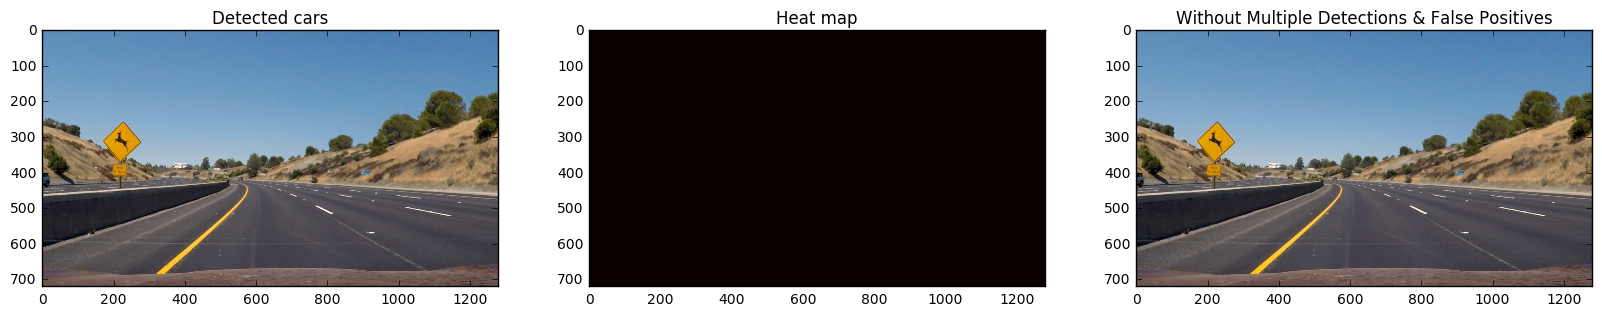

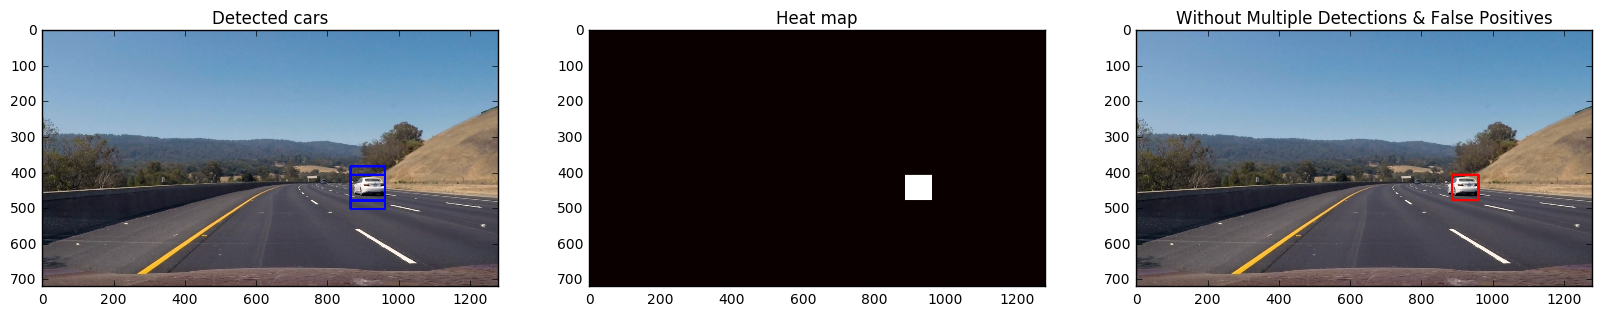

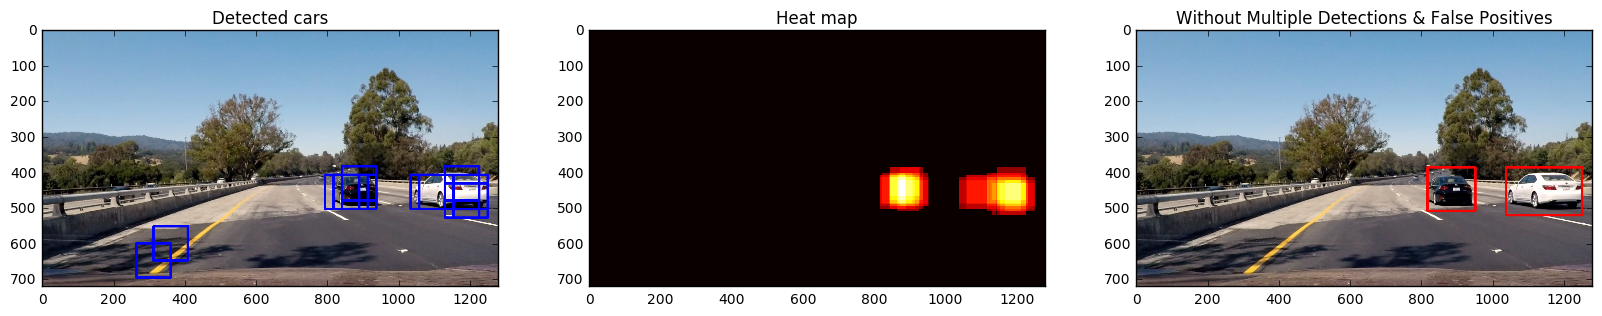

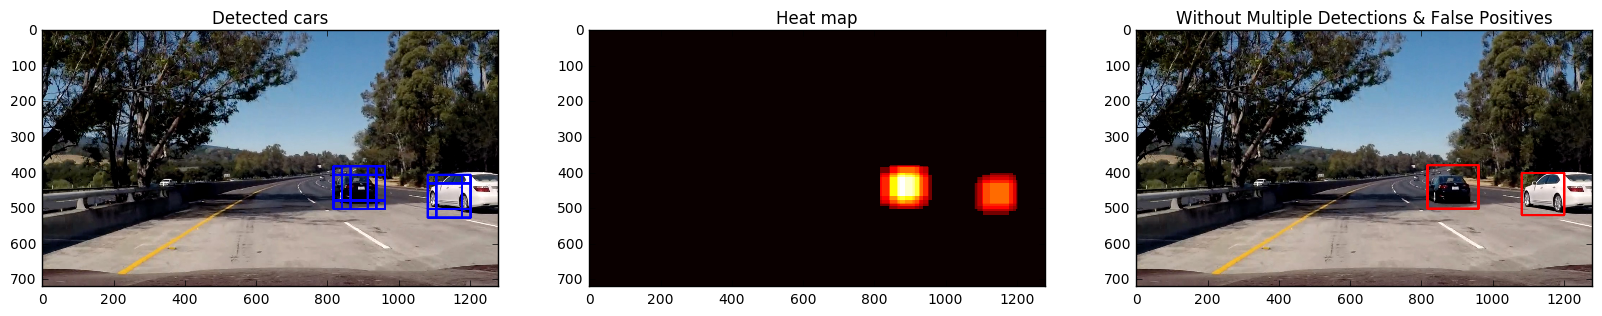

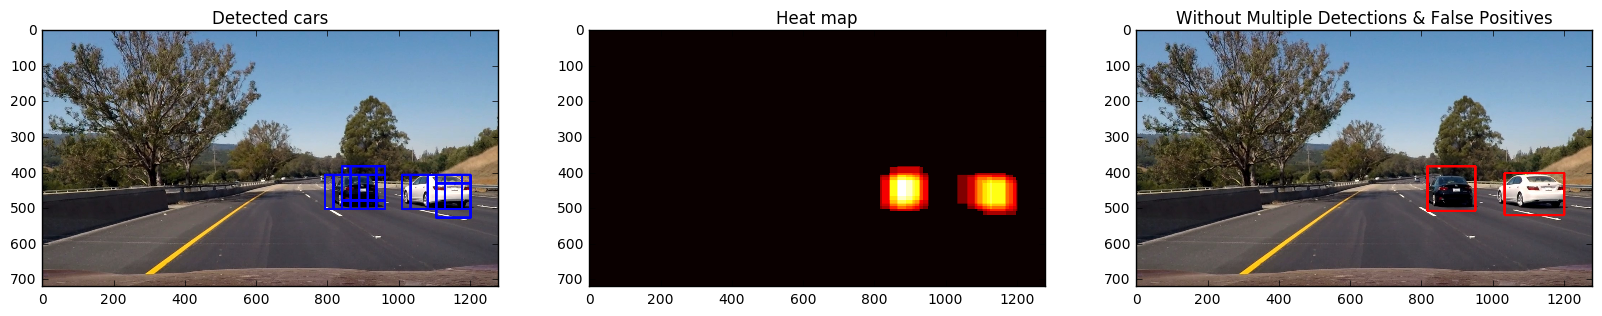

In [13]:
for img_file in test_files:
    image = cv2.imread(img_file)
    output_img = np.copy(image)
    detected_windows = []
    corrected_windows = np.zeros_like(image[:,:,0])
    #Extract features using hog sub-sampling and make predictions
    scales = [1.35, 1.7, 1.5]
    
    for scale in scales:
        draw , heatmap = find_cars(image , scale = scale)
        corrected_windows += heatmap
        
    detected_windows = draw
    heatmap = apply_threshold(corrected_windows , threshold = 2)
    labels = label(heatmap)
    output_img = draw_labeled_boxes(output_img,labels)

    f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize =(20,10))
    ax1.imshow(cv2.cvtColor(detected_windows,cv2.COLOR_BGR2RGB))
    ax2.imshow(corrected_windows,cmap = 'hot')
    ax3.imshow(cv2.cvtColor(output_img,cv2.COLOR_BGR2RGB))
    ax1.set_title('Detected cars')
    ax2.set_title('Heat map')
    ax3.set_title('Without Multiple Detections & False Positives')   
    plt.show()

In [14]:
buffer_size = 10
cumulative_heat = np.zeros((buffer_size,720,1280))
nFrames = 0
def process_image(image):
    global cumulative_heat
    global nFrames
    global buffer_size
    corrected_frame =[]
    alpha, beta = 0.6, 0.4

    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    output_img = np.copy(image)
    
    scales = [1.35, 1.7, 1.5]
    
    _ , heatmap = find_cars(image , scale = 1.35)
    corrected_frame =  heatmap
    _ , heatmap = find_cars(image , scale = 1.7)
    corrected_frame += heatmap
#     _ , heatmap = find_cars(image , scale = 1.45)
#     frame_heat += heatmap
    _ , heatmap = find_cars(image , scale = 1.5)
    corrected_frame += heatmap
    
    #for scale in scales:
        #draw , heatmap = find_cars(image , scale = scale)
        #corrected_frame += heatmap

    heatmap  = beta * corrected_frame + alpha * np.mean(cumulative_heat,axis = 0)
    
    heatmap = apply_threshold(heatmap , threshold = 2.5)
    cumulative_heat[nFrames] = corrected_frame

    nFrames = (nFrames + 1) % buffer_size
    labels = label(heatmap)
    output_img = draw_labeled_boxes(output_img,labels)
    output_img = cv2.cvtColor(output_img,cv2.COLOR_BGR2RGB)
    return output_img

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
out_video = 'out_vehicle_detect3.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(out_video, audio=False)